### Librerias 

In [1]:
import os
import squarify
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Latex
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
plt.style.use("dark_background")

# Hipotesis nula: La canasta basica familiar durante los proximos 10 años se encarecera significativamente en el Peru y en Sudamerica.

In [2]:
path = "../FAO_UPDATED_DATA/"
path_2 = "data_2/"
files = [path+file for file in os.listdir(path) if not "ipynb" in file]

In [28]:
def nearest_neighbor_by_table(path,columns,country):

    df = pd.read_csv(path)
    df_pivot = df.pivot(index="Area",columns=columns,values="Value")
    df_pivot = df_pivot.fillna(0)

    nn_cos = NearestNeighbors(n_neighbors=df_pivot.shape[0],metric="cosine")
    nn_cos.fit(df_pivot)
    
    diferencia,paises = nn_cos.kneighbors(df_pivot[df_pivot.index==country].values[0].reshape(1,-1))
    paises = df_pivot.iloc[paises.reshape(-1,)].index
    diferencia = diferencia.reshape(-1,)
    rango = [a for a in range(10)]#+[a for a in range(-5,0)]

    return {"y":diferencia[rango],"x":paises[rango]}

def random_plot_nn_tables(files,path,country):

    fig = plt.Figure(figsize=(24,18))
    for a in range(8):
        file_name = files[a]
        if "suite" in file_name: continue
        file_name = path+file_name
        ax = fig.add_subplot(3,3,a+1)
        if not "Months" in pd.read_csv(file_name).columns:
            columns = ["Domain","Year","Unit","Element","Item"]
        else:
            columns = ["Year","Months","Unit","Item"]

        try:
            data = nearest_neighbor_by_table(path=file_name,
                                        columns=columns,
                                        country=country)
        except: continue
        sub_fig = sns.barplot(data=data,x="y",y="x",ax=ax,palette="magma_r")
        q = file_name.split("/")[-1].split(".")[0]
        sub_fig.set_xlabel(f"cosine similarity between all metrics related to {q}")
        sub_fig.set_ylabel("")

        sub_fig.set(title=q)
    fig.suptitle(f"The 10 nearest countries in the period 2008-2020 to {country} at ...",fontsize=36)
    
    fig.subplots_adjust(wspace=0.4,top=0.92,hspace=0.2)
    return fig


In [29]:
qq = os.listdir(path_2)
country = "Chile"
fig = random_plot_nn_tables(qq,path_2,country)

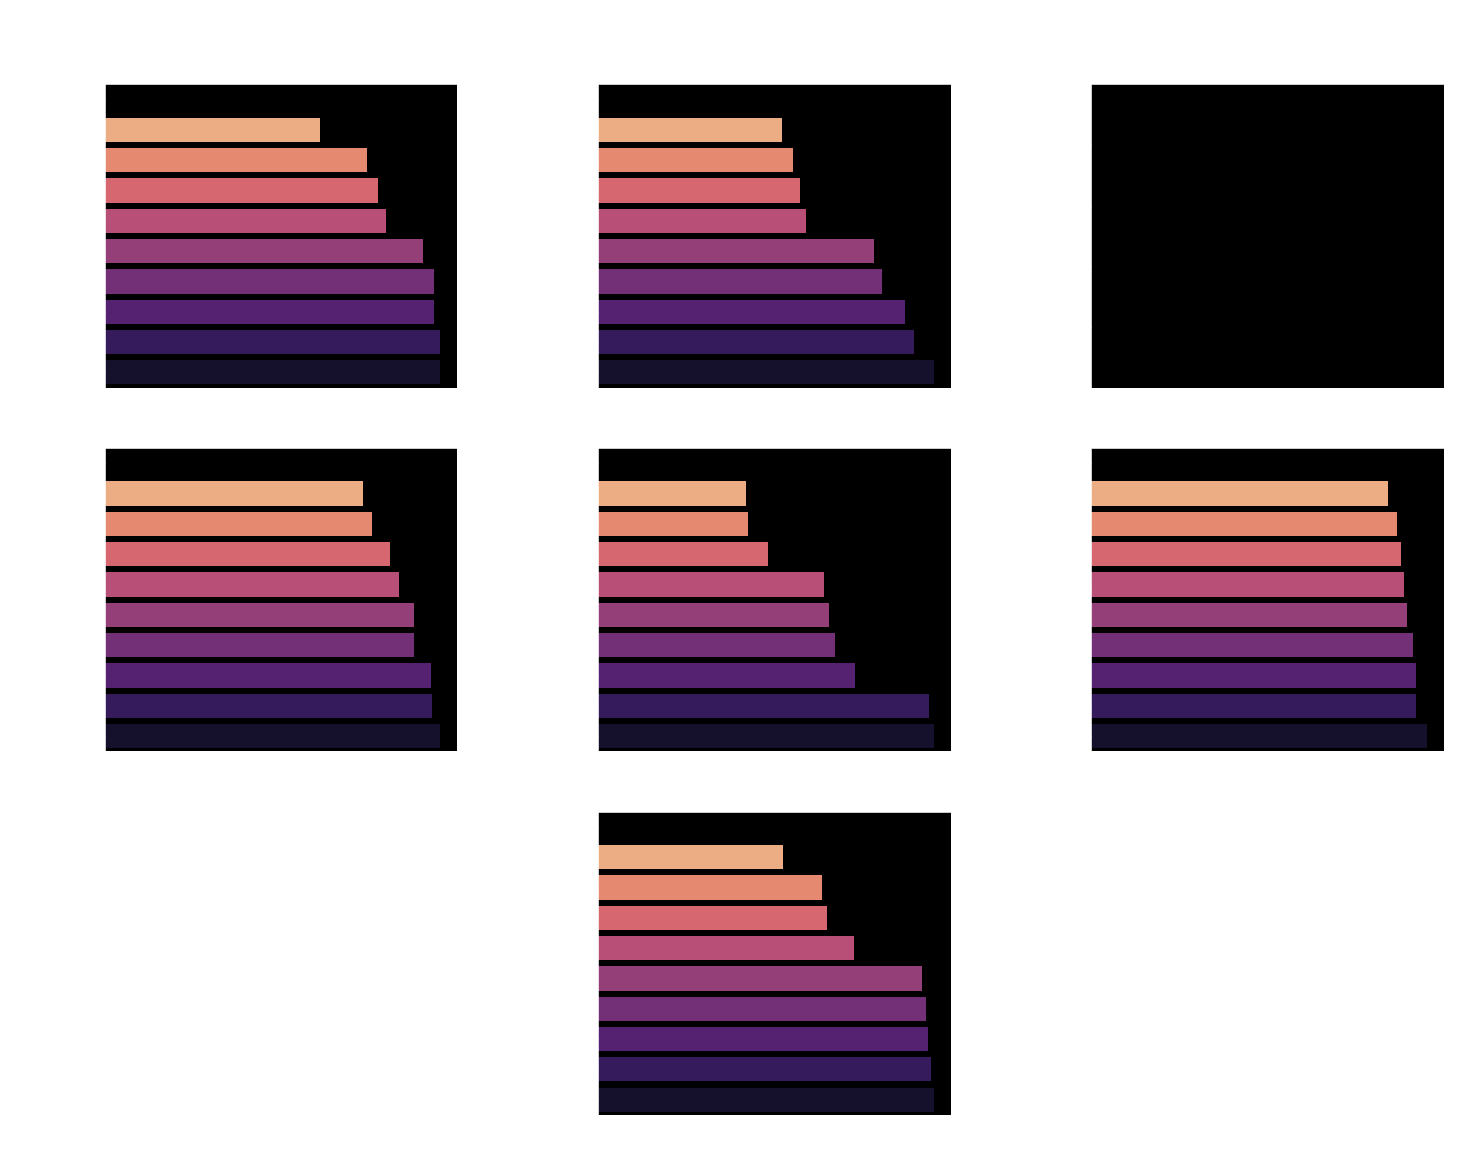

In [30]:
fig

In [39]:
#main_df_cluster = pd.concat([pd.read_csv(path_2+file) for file in os.listdir(path_2)])

main_df_cluster = []

for file in os.listdir(path_2):
    file = path_2+file
    if "suite_of" in file or "ipynb" in file or "credit" in file: continue
    df = pd.read_csv(file)
    cols = ["Domain","Area","Element","Item","Year","Unit","Value"]
    if "Months" in df.columns:
        df = df.loc[df.Months=="December"]
    if not "Element" in df.columns:
        df["Element"] = df.Domain.unique()[0]
    df = df[cols]
    main_df_cluster.append(df)

In [40]:
main_df = pd.concat(main_df_cluster)

In [49]:
qq = main_df[main_df.Domain=="Producer Prices"].Item.unique()

resq = ["Supply Utilization Accounts","Crops and livestock products","Suite of Food Security Indicators"]

main_df = main_df[(~main_df.Domain.isin(resq))|(main_df.Item.isin(qq))]

main_df["Unit"] = main_df.Unit.fillna("unknown")

In [50]:
pivot_resume_df = main_df.pivot(index="Area",columns=["Domain","Year","Unit","Element","Item"],values="Value").fillna(0)

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [53]:
nn_cos = NearestNeighbors(n_neighbors=20,metric="cosine")
nn_cos.fit(pivot_resume_df)
country = "Peru"
diferencia,paises = nn_cos.kneighbors(pivot_resume_df[pivot_resume_df.index==country].values[0].reshape(1,-1))
paises = pivot_resume_df.iloc[paises.reshape(-1,)].index
diferencia = diferencia.reshape(-1,)

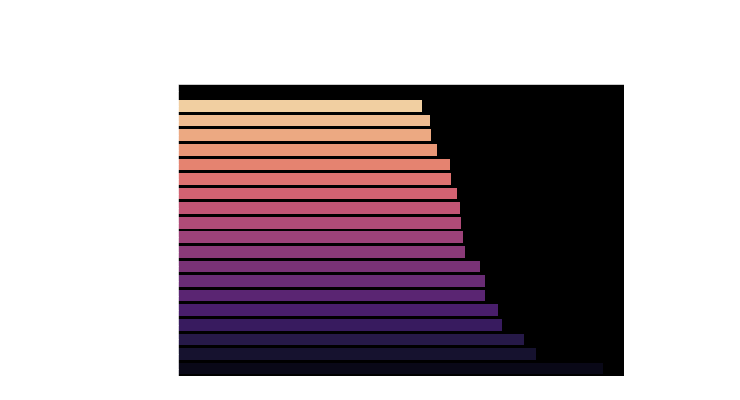

In [140]:
ax,fig = plt.subplots(figsize=(8,6))
fig = sns.barplot(data={"y":diferencia,"x":paises},y="x",x="y",palette="magma_r")

fig.figure.suptitle(f"The closest countries with a similar agricultural dynamic\n to {country} based on Nearest Neighbor model",fontsize=24)
fig.figure.subplots_adjust(top=0.8)
plt.show()

In [3]:
files = sorted(files)

col_br_ur_trade_matrix = pd.read_csv(files[0])
consumer_price = pd.read_csv(files[1])
consumer_price["Element"] = "consumer_price"
country_investment = pd.read_csv(files[2])
credit = pd.read_csv(files[7])
crops_products = pd.read_csv(files[12])
development_flow = pd.read_csv(files[3])
exchange_rates = pd.read_csv(files[4])
fertilizers_by_product = pd.read_csv(files[5])
fertilizers_indicators = pd.read_csv(files[6])
macro_indicators = pd.read_csv(files[8])
peru_chile_trade_matrix = pd.read_csv(files[9])
producer_prices = pd.read_csv(files[10])
supply = pd.read_csv(files[11],encoding="ISO-8859-1")

/tmp/ipykernel_207/2281316458.py:9: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  development_flow = pd.read_csv(files[3])


In [40]:
qqqq = supply.pivot(index=["Area","Year","Element"],columns="Item",values="Value").fillna(0)
qqqq.reset_index().groupby(["Area","Element"])[qqqq.columns[5:7]].corr()

Item                                                                  Apple juice  \
Area    Element                            Item                                     
Brazil  Calories/Year                      Apple juice                   1.000000   
                                           Apple juice, concentrated    -0.413881   
        Export Quantity                    Apple juice                   1.000000   
                                           Apple juice, concentrated    -0.438416   
        Fat supply quantity (g/capita/day) Apple juice                        NaN   
...                                                                           ...   
Uruguay Seed                               Apple juice, concentrated          NaN   
        Stock Variation                    Apple juice                   1.000000   
                                           Apple juice, concentrated     0.106715   
        Tourist consumption                Apple juice                        NaN   
                                           Apple juice, concentrated          NaN   

Item                                                                  Apple juice, concentrated  
Area    Element                            Item                                                  
Brazil  Calories/Year                      Apple juice                                -0.413881  
                                           Apple juice, concentrated                   1.000000  
        Export Quantity                    Apple juice                                -0.438416  
                                           Apple juice, concentrated                   1.000000  
        Fat supply quantity (g/capita/day) Apple juice                                      NaN  
...                                                                                         ...  
Uruguay Seed                               Apple juice, concentrated                        NaN  
        Stock Variation                    Apple juice                                 0.106715  
                                           Apple juice, concentrated                   1.000000  
        Tourist consumption                Apple juice                                      NaN  
                                           Apple juice, concentrated                        NaN  

[200 rows x 2 columns]

In [141]:
from typing import Optional

class DataInsightsFAO:
    def __init__(self,df:pd.DataFrame,
                 method:str,
                 element_name:str,
                 list_items:Optional[list]=[],
                 list_elements:Optional[list]=[]):
        
        self.df = df
        self.method = method
        self.element_name = element_name
        self.list_items = list_items
        self.list_elements = list_elements

    def transform_data_1(self,method="direct") -> pd.DataFrame:
        if len(self.list_items)!=0:
            items_df = self.df.Item.isin(self.list_items)
        else:
            items_df = 1
        if len(self.list_elements)!=0:
            items_df = self.df.Element.isin(self.list_elements)
        else:
            elements_df = 1
            
        main_df = self.df.loc[(items_df)&(elements_df)&(self.df.Element==self.element_name)]

        if self.method=="grouped_sum":
            main_df = main_df.groupby(["Year","Area","Item","Unit"]).Value.sum().reset_index()
        if self.method=="grouped_mean":
            main_df = main_df.groupby(["Year","Area","Item","Unit"]).Value.mean().reset_index()
        if self.method=="direct":
            main_df = main_df[["Year","Area","Item","Unit","Value"]]

        return main_df
    
    def plot_data_1(self,kind="bar",palette="bright"):
        main_df = self.transform_data()
        fig = sns.catplot(data=main_df,
                        x="Year",y="Value",col="Area",hue="Item",
                        kind=kind,height=6,palette=palette,col_wrap=3)
        return fig
    
        



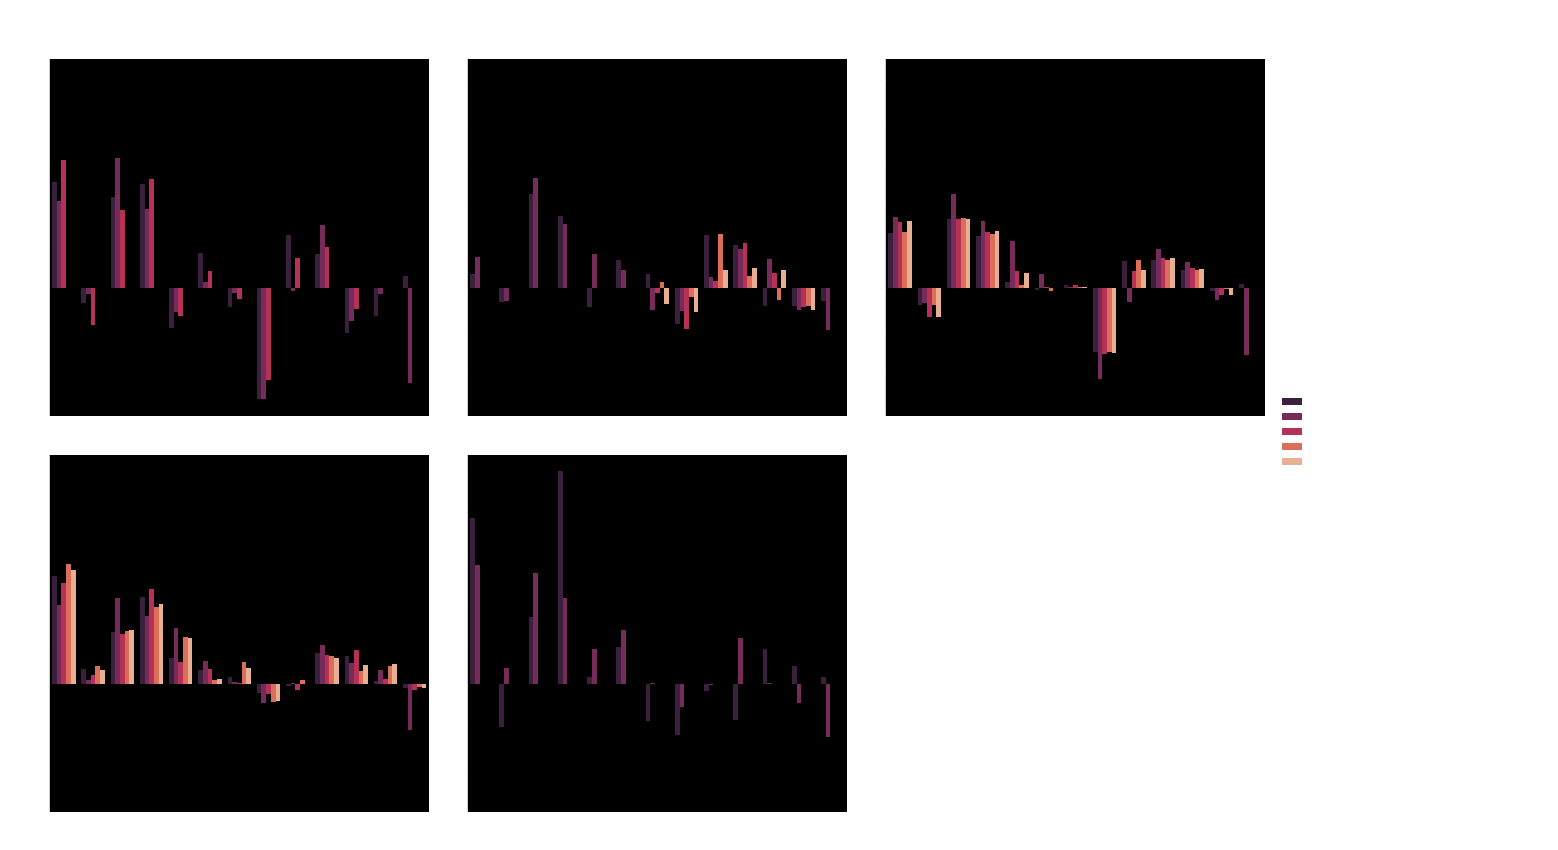

In [152]:
str_1 = ["Value Added (Agriculture)","Value Added (Agriculture, Forestry and Fishing)",
        "Gross Output (Agriculture)","Gross Output (Agriculture, Forestry and Fishing)",
        "Gross National Income"]

fig = DataInsightsFAO(macro_indicators,element_name="Annual growth US$",method="direct",list_items=str_1).plot_data(kind="bar",palette="rocket")

fig.figure.suptitle("Annual growth US$",fontsize=24)
fig.figure.subplots_adjust(top=0.92,wspace=0.1)
plt.show()

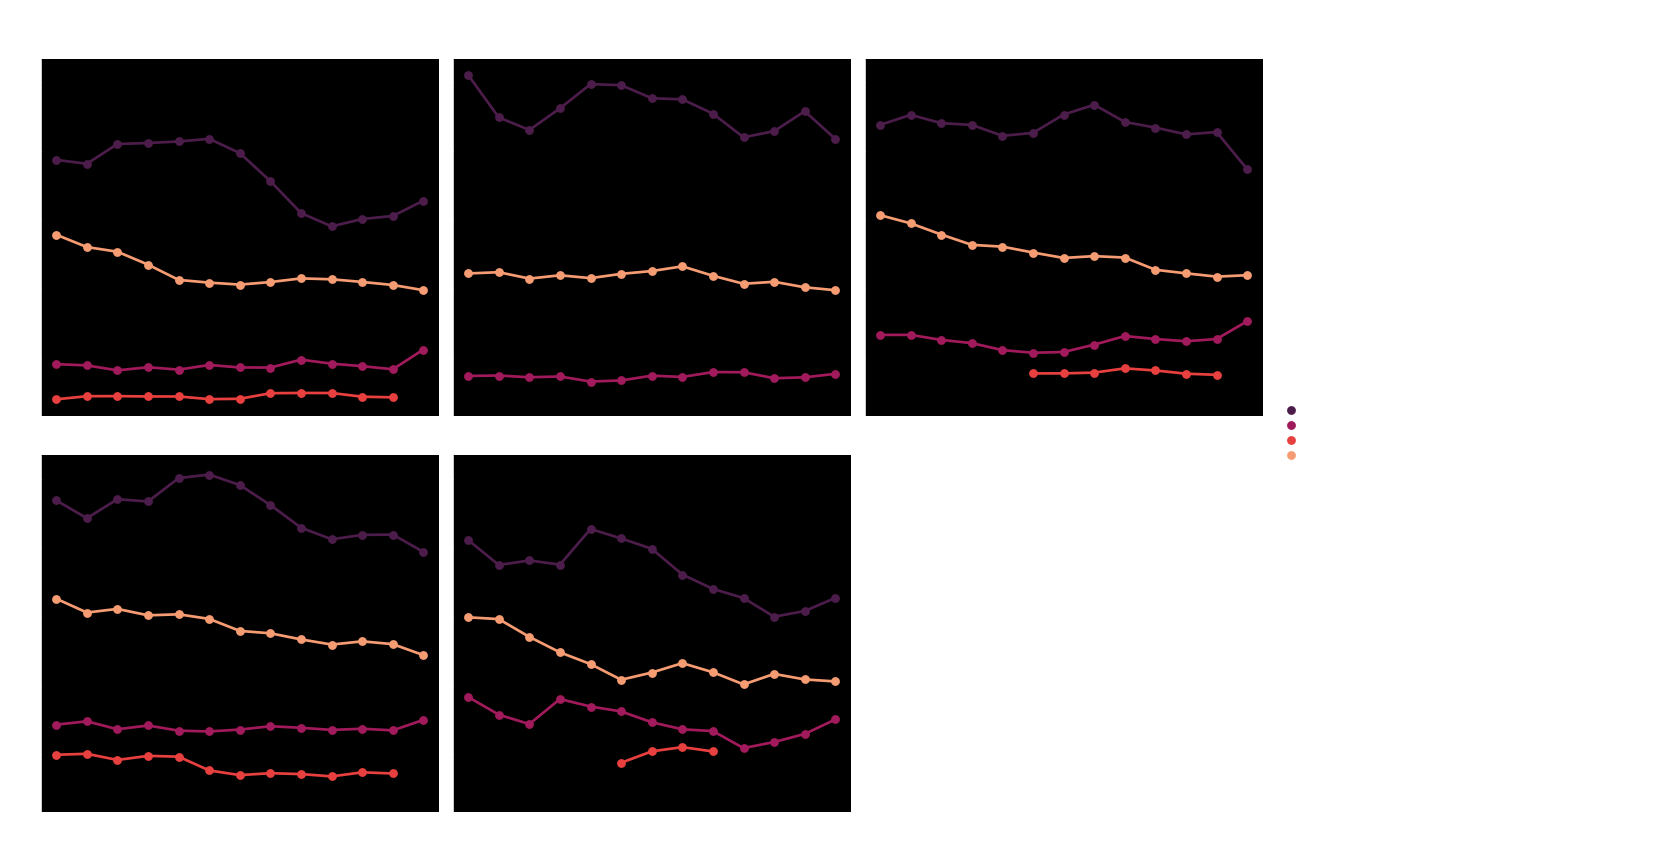

In [153]:
fig = DataInsightsFAO(macro_indicators,element_name="Share of GDP US$",method="grouped_mean").plot_data(kind="point",palette="rocket")

fig.figure.suptitle("Share of GDP US$",fontsize=24)
fig.figure.subplots_adjust(top=0.92)
plt.show()

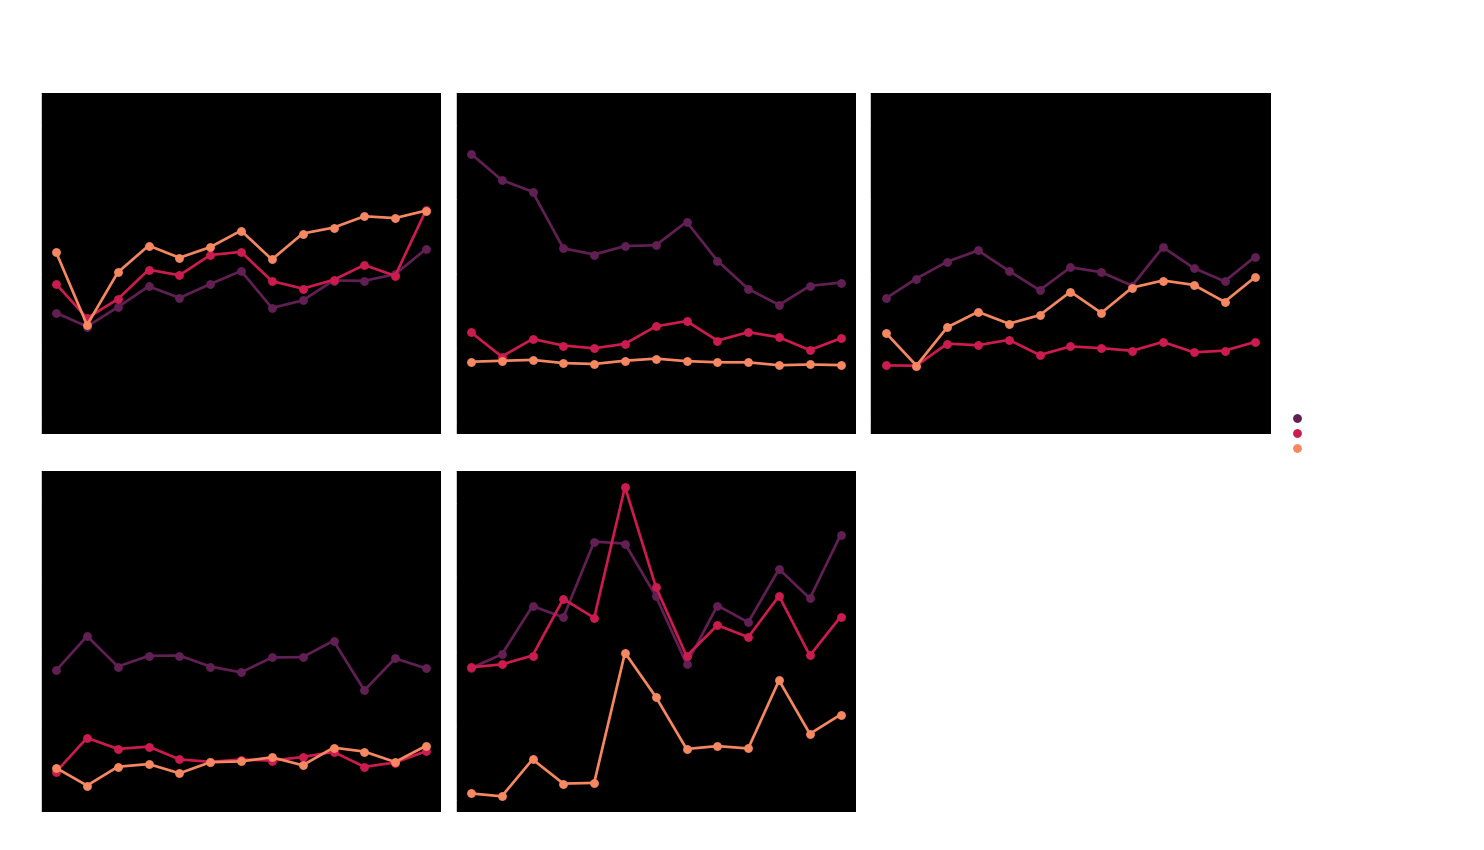

In [154]:
fig = DataInsightsFAO(fertilizers_indicators,
                      element_name="Use per value of agricultural production",
                      method="direct").plot_data(kind="point",palette="rocket")

fig.figure.suptitle(" Use of fertilizers per value of agricultural\n production kg/1000 Int.$",fontsize=24)
fig.figure.subplots_adjust(top=0.88)
plt.show()

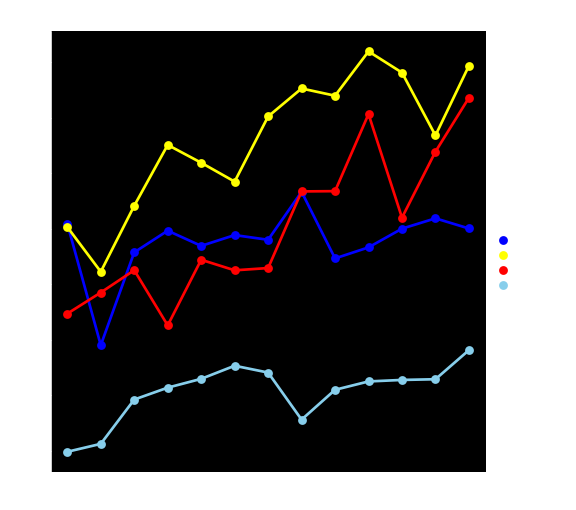

In [116]:
q_4 = fertilizers_by_product.loc[(fertilizers_by_product.Element.isin(["Import Quantity"]))&
                                (fertilizers_by_product.Area!="Brazil")].groupby(["Year","Area"]).Value.sum()

q_4 = q_4.reset_index()

fig = sns.catplot(data=q_4,x="Year",y="Value",hue="Area",kind="point",height=7,palette=["Blue","Yellow","Red","SkyBlue"])

plt.title("Import Quantity of Fertilizers per Country",fontsize=24)
plt.show()

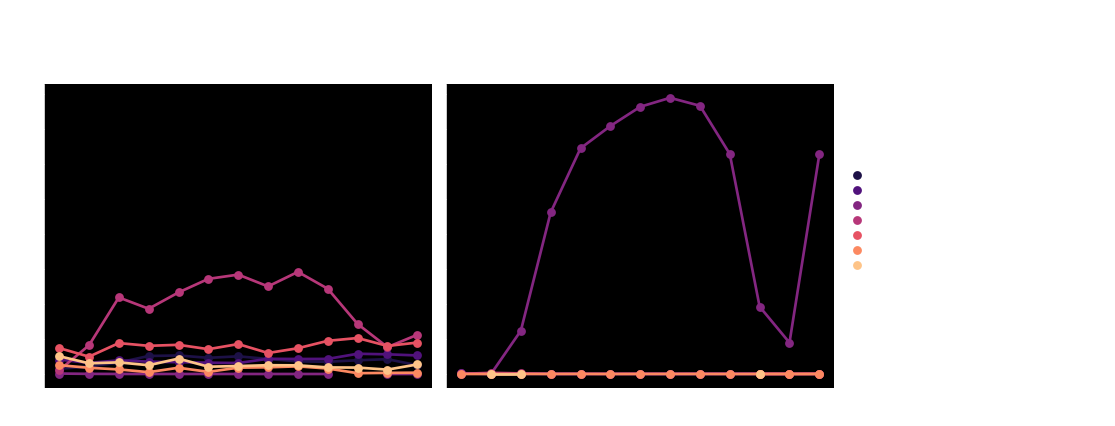

In [121]:
q_3 = fertilizers_by_product.loc[(fertilizers_by_product.Element.isin(["Export Quantity"]))&
                                (fertilizers_by_product.Area.isin(["Chile","Peru"]))]

q_4 = q_3.groupby(["Year","Area","Item"]).Value.sum()

q_4 = q_4.reset_index()

q_5 = q_3.groupby(["Area","Item"]).Value.sum().reset_index()

q_5 = q_5.loc[q_5.Value>0.5e+6].Item.unique()

q_4 = q_4.loc[q_4.Item.isin(q_5)]

fig = sns.catplot(data=q_4,x="Year",y="Value",hue="Item",
            color="Value",col="Area",kind="point",palette="magma",
            height=6,col_wrap=2)

fig.figure.suptitle("Fertilizers by product on South America\n where the export quantity its higher",fontsize=24)
fig.figure.subplots_adjust(top=0.8)
plt.show()

In [122]:
trade_matrix = pd.concat([col_br_ur_trade_matrix,peru_chile_trade_matrix])

trade_matrix_2 = trade_matrix.pivot(index=["Reporter Countries","Partner Countries","Year","Item"],
                   columns=["Element"],
                   values="Value")

trade_matrix_2 = trade_matrix_2.reset_index()
trade_matrix_2 = trade_matrix_2.fillna(0)

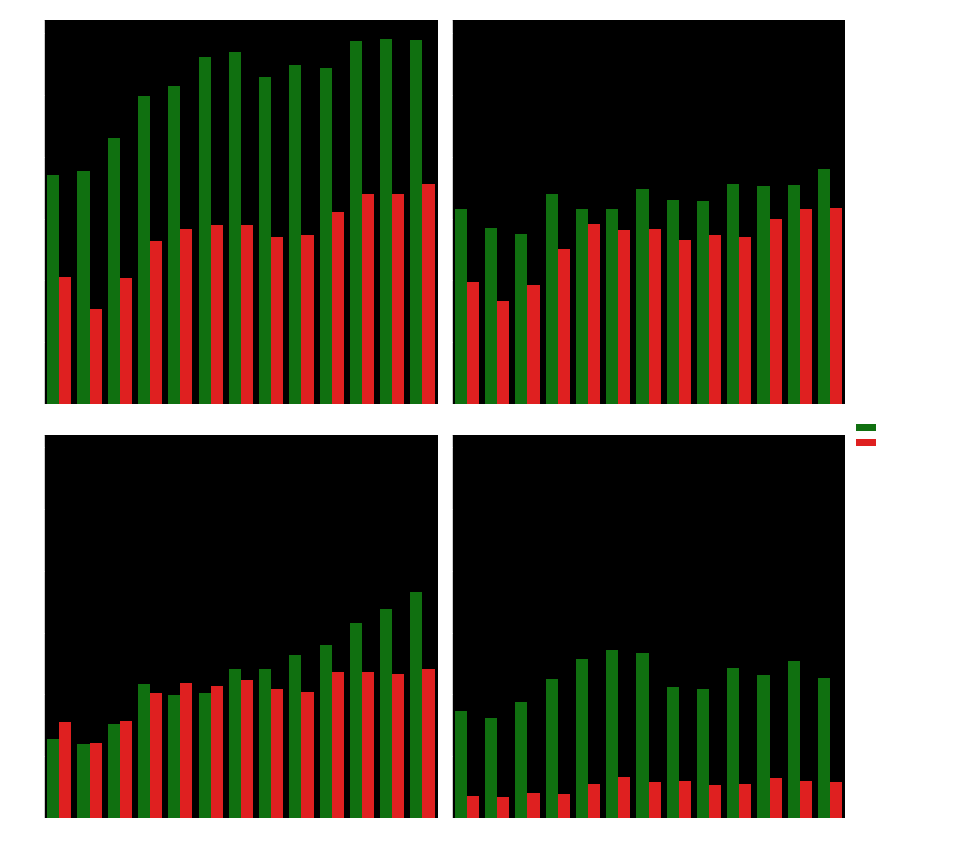

In [123]:
q = trade_matrix.groupby(["Reporter Countries","Element","Year"]).Value.sum()
q = q.reset_index()
q = q.loc[q["Reporter Countries"]!="Brazil"]

sns.catplot(data=q,x="Year",y="Value",hue="Element",
            col="Reporter Countries",kind="bar",
            height=6,palette=["Green","Red"],col_wrap=2)
plt.show()

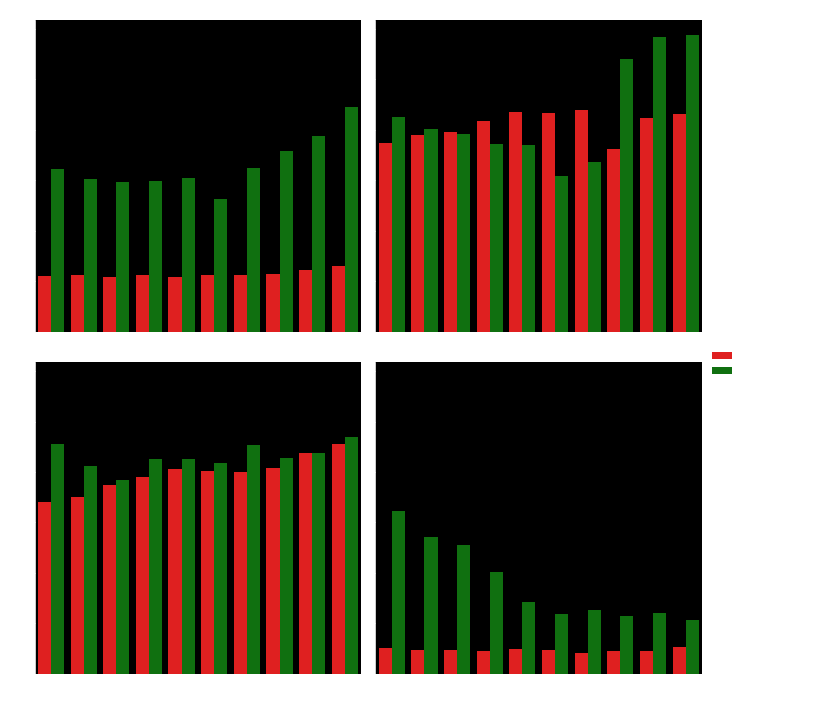

In [124]:
list_of_elements = ["Loss","Opening stocks"]

q = supply[(supply.Area!="Brazil")&
           (supply.Element.isin(list_of_elements))
          ].groupby(["Area","Year","Element"]).sum().reset_index()

sns.catplot(data=q,x="Year",y="Value",hue="Element",col="Area",kind="bar",palette=["Red","Green"],col_wrap=2)
plt.show()